# SVD/DMD analysis of surface pressure coefficients

In [1]:
from os import makedirs
import numpy as np
import torch as pt
from scipy.signal import welch
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from flowtorch.data import mask_box
from flowtorch.analysis import SVD, DMD
from utils import add_stl_patch, normalize_frequency
from flow_conditions import CHORD, A_INF

plt.rcParams['figure.dpi'] = 160
plt.rc('text', usetex=True)

data = "./output/naca0012_data/surface/"
output = "./output/naca0012_analysis/surface/"
makedirs(output, exist_ok=True)

## Temporal mean and standard deviation

In [2]:
vert_z25 = pt.load(data + "vertices_ref0_z25.pt")
times_z25 = pt.load(data + "times_ref0_z25.pt")
dm_z25 = pt.load(data + "dm_ref0_z25.pt")
vert_r1_z25 = pt.load(data + "vertices_ref1_z25.pt")
times_r1_z25 = pt.load(data + "times_ref1_z25.pt")
dm_r1_z25 = pt.load(data + "dm_ref1_z25.pt")
vert_z50 = pt.load(data + "vertices_ref0_z50.pt")
times_z50 = pt.load(data + "times_ref0_z50.pt")
dm_z50 = pt.load(data + "dm_ref0_z50.pt")

In [3]:
# determine start index for time to remove initial numerical transient phase
# the starting time is chosen based on the lift coefficient analysis
start_idx = pt.argmin((times_z25 - 0.0325).abs())
print(start_idx, times_z25[start_idx])
print(start_idx, times_r1_z25[start_idx])
print(start_idx, times_z50[start_idx])

tensor(324) tensor(0.0325)
tensor(324) tensor(0.0325)
tensor(324) tensor(0.0325)


In [4]:
# normalize vertices with chord length
vert_z25 = (vert_z25 - vert_z25[:, 0].min()) / (vert_z25[:, 0].max() - vert_z25[:, 0].min())
vert_r1_z25 = (vert_r1_z25 - vert_r1_z25[:, 0].min()) / (vert_r1_z25[:, 0].max() - vert_r1_z25[:, 0].min())
vert_z50 = (vert_z50 - vert_z50[:, 0].min()) / (vert_z50[:, 0].max() - vert_z50[:, 0].min())

In [5]:
# dimensionless times
dtimes_z25 = times_z25 * A_INF / CHORD
dtimes_r1_z25 = times_r1_z25 * A_INF / CHORD
dtimes_z50 = times_z50 * A_INF / CHORD

In [6]:
# check how mean and std. change with increasing number of snapshots
window_mean_z25 = [dm_z25[:, start_idx:i].mean() for i in range(start_idx, dm_z25.shape[-1])]
window_std_z25 = [dm_z25[:, start_idx:i].std() for i in range(start_idx, dm_z25.shape[-1])]
window_mean_r1_z25 = [dm_r1_z25[:, start_idx:i].mean() for i in range(start_idx, dm_r1_z25.shape[-1])]
window_std_r1_z25 = [dm_r1_z25[:, start_idx:i].std() for i in range(start_idx, dm_r1_z25.shape[-1])]
window_mean_z50 = [dm_z50[:, start_idx:i].mean() for i in range(start_idx, dm_z50.shape[-1])]
window_std_z50 = [dm_z50[:, start_idx:i].std() for i in range(start_idx, dm_z50.shape[-1])]

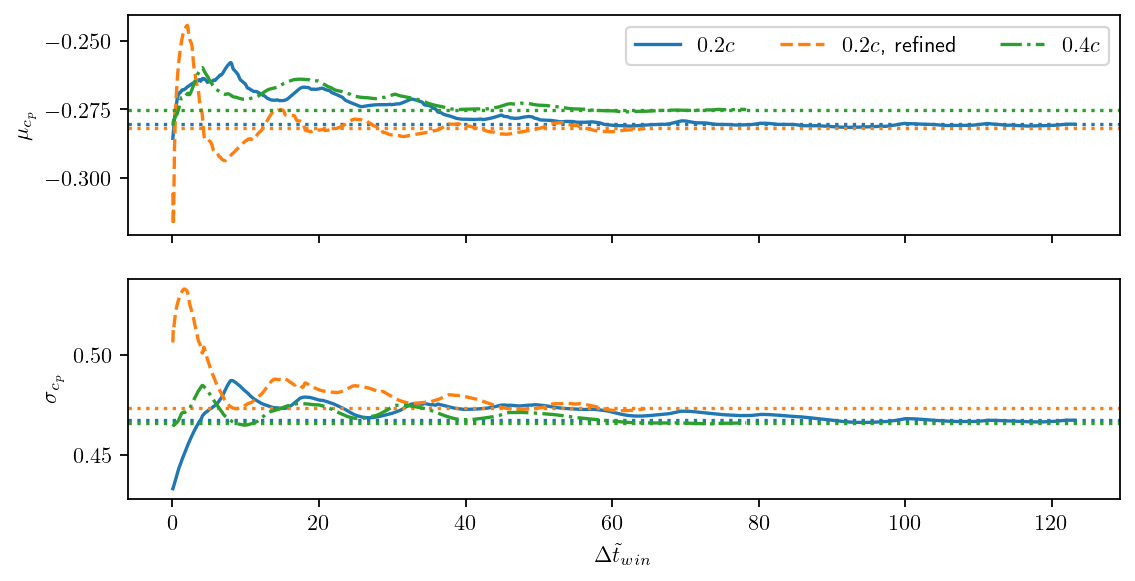

In [7]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 4), sharex=True)
ax1.plot(dtimes_z25[start_idx:]-dtimes_z25[start_idx], window_mean_z25, c="C0", ls="-", label=r"$0.2c$")
ax1.axhline(window_mean_z25[-1], c="C0", ls=":")
ax2.plot(dtimes_z25[start_idx:]-dtimes_z25[start_idx], window_std_z25, c="C0", ls="-",)
ax2.axhline(window_std_z25[-1], c="C0", ls=":")
ax1.plot(dtimes_r1_z25[start_idx:]-dtimes_r1_z25[start_idx], window_mean_r1_z25, c="C1", ls="--", label=r"$0.2c$, refined")
ax1.axhline(window_mean_r1_z25[-1], c="C1", ls=":")
ax2.plot(dtimes_r1_z25[start_idx:]-dtimes_r1_z25[start_idx], window_std_r1_z25, c="C1", ls="--",)
ax2.axhline(window_std_r1_z25[-1], c="C1", ls=":")
ax1.plot(dtimes_z50[start_idx:]-dtimes_z50[start_idx], window_mean_z50, c="C2", ls="-.", label=r"$0.4c$")
ax1.axhline(window_mean_z50[-1], c="C2", ls=":")
ax2.plot(dtimes_z50[start_idx:]-dtimes_z50[start_idx], window_std_z50, c="C2", ls="-.",)
ax2.axhline(window_std_z50[-1], c="C2", ls=":")

ax1.legend(ncol=3)
ax1.set_ylabel(r"$\mu_{c_p}$")
ax2.set_ylabel(r"$\sigma_{c_p}$")
ax2.set_xlabel(r"$\Delta\tilde{t}_{win}$")
plt.show()

In [8]:
# compute relative difference of final mean and std. with respect to 0.2c case
mu_ref = window_mean_z25[-1]
print("Deviation of final mean value:")
print("0.2c, refined: {:2.4f}%".format((window_mean_r1_z25[-1] - mu_ref) / mu_ref * 100))
print("0.4c: {:2.4f}%".format((window_mean_z50[-1] - mu_ref) / mu_ref * 100))
sig_ref = window_std_z25[-1]
print("Deviation of final standard deviation:")
print("0.2c, refined: {:2.4f}%".format((window_std_r1_z25[-1] - sig_ref) / sig_ref * 100))
print("0.4c: {:2.4f}%".format((window_std_z50[-1] - sig_ref) / sig_ref * 100))

Deviation of final mean value:
0.2c, refined: 0.5264%
0.4c: -1.8950%
Deviation of final standard deviation:
0.2c, refined: 1.2528%
0.4c: -0.2763%


In [9]:
# creating masks for lower and upper side
mask_z25_up = mask_box(vert_z25, [-0.1, 0.0, -0.5], [0.999, 1.0, 0.5])
mask_z25_low = mask_box(vert_z25, [-0.1, -1.0, -0.5], [0.999, 0.0, 0.5])
mask_z25_r1_up = mask_box(vert_r1_z25, [-0.1, 0.0, -0.5], [0.999, 1.0, 0.5])
mask_z25_r1_low = mask_box(vert_r1_z25, [-0.1, -1.0, -0.5], [0.999, 0.0, 0.5])
mask_z50_up = mask_box(vert_z50, [-0.1, 0.0, -0.5], [0.999, 1.0, 0.5])
mask_z50_low = mask_box(vert_z50, [-0.1, -1.0, -0.5], [0.999, 0.0, 0.5])
print("Points 0.2c lower/upper side, r0: ", mask_z25_up.sum().item(), mask_z25_low.sum().item())
print("Points 0.2c lower/upper side, r1: ", mask_z25_r1_up.sum().item(), mask_z25_r1_low.sum().item())
print("Points 0.4c lower/upper side, r0: ", mask_z50_up.sum().item(), mask_z50_low.sum().item())

Points 0.2c lower/upper side, r0:  4550 4550
Points 0.2c lower/upper side, r1:  6240 6240
Points 0.4c lower/upper side, r0:  8925 8925


In [10]:
# sub-select vertices for plotting
x_z25_up = pt.masked_select(vert_z25[:, 0], mask_z25_up)
z_z25_up = pt.masked_select(vert_z25[:, 2], mask_z25_up)
x_z25_low = pt.masked_select(vert_z25[:, 0], mask_z25_low)
z_z25_low = pt.masked_select(vert_z25[:, 2], mask_z25_low)
x_z25_r1_up = pt.masked_select(vert_r1_z25[:, 0], mask_z25_r1_up)
z_z25_r1_up = pt.masked_select(vert_r1_z25[:, 2], mask_z25_r1_up)
x_z50_up = pt.masked_select(vert_z50[:, 0], mask_z50_up)
z_z50_up = pt.masked_select(vert_z50[:, 2], mask_z50_up)
x_z50_low = pt.masked_select(vert_z50[:, 0], mask_z50_low)
z_z50_low = pt.masked_select(vert_z50[:, 2], mask_z50_low)

In [11]:
end_idx = pt.argmin((times_z25 - 0.1015).abs())
print(end_idx, times_z25[end_idx])
print(end_idx, times_r1_z25[end_idx])
print(end_idx, times_z50[end_idx])

tensor(1014) tensor(0.1015)
tensor(1014) tensor(0.1015)
tensor(1014) tensor(0.1015)


In [12]:
start_idx, end_idx, end_idx-start_idx, times_z25[end_idx]

(tensor(324), tensor(1014), tensor(690), tensor(0.1015))

In [13]:
# creating data matrices for lower and upper side
dm_z25_up = pt.zeros((mask_z25_up.sum().item(), end_idx.item()-start_idx.item()))
dm_z25_low = pt.zeros((mask_z25_low.sum().item(), end_idx.item()-start_idx.item()))
dm_z25_r1_up = pt.zeros((mask_z25_r1_up.sum().item(), end_idx.item()-start_idx.item()))
dm_z50_up = pt.zeros((mask_z50_up.sum().item(), end_idx.item()-start_idx.item()))
dm_z50_low = pt.zeros((mask_z50_low.sum().item(), end_idx.item()-start_idx.item()))

for i in range(end_idx.item()-start_idx.item()):
    dm_z25_up[:, i] = pt.masked_select(dm_z25[:, start_idx.item()+i], mask_z25_up)
    dm_z25_low[:, i] = pt.masked_select(dm_z25[:, start_idx.item()+i], mask_z25_low)
    dm_z25_r1_up[:, i] = pt.masked_select(dm_r1_z25[:, start_idx.item()+i], mask_z25_r1_up)
    dm_z50_up[:, i] = pt.masked_select(dm_z50[:, start_idx.item()+i], mask_z50_up)
    dm_z50_low[:, i] = pt.masked_select(dm_z50[:, start_idx.item()+i], mask_z50_low)

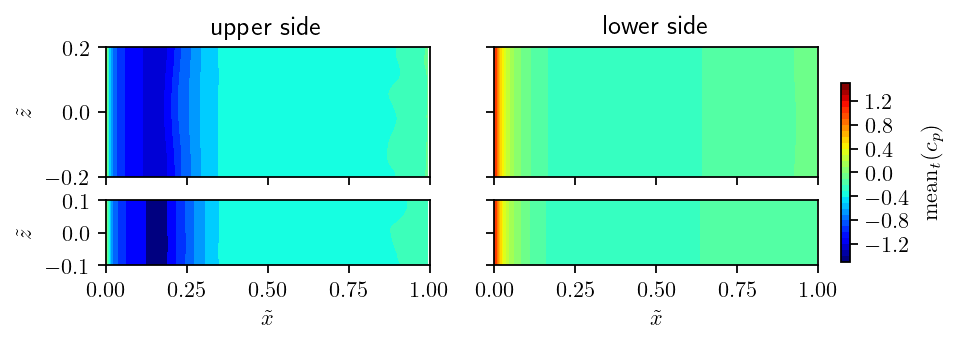

In [14]:
fig, axarr = plt.subplots(2, 2, figsize=(6, 3), sharex=True)

cp_min = -1.5
cp_max = 1.5

tri = axarr[1, 0].tricontourf(x_z25_up, z_z25_up, dm_z25_up[:, start_idx:].mean(dim=1), levels=15, cmap="jet", vmin=cp_min, vmax=cp_max, extend="both")
axarr[1, 1].tricontourf(x_z25_low, z_z25_low, dm_z25_low[:, start_idx:].mean(dim=1), levels=15, cmap="jet", vmin=cp_min, vmax=cp_max)
axarr[0, 0].tricontourf(x_z50_up, z_z50_up, dm_z50_up[:, start_idx:].mean(dim=1), levels=15, cmap="jet", vmin=cp_min, vmax=cp_max)
axarr[0, 1].tricontourf(x_z50_low, z_z50_low, dm_z50_low[:, start_idx:].mean(dim=1), levels=15, cmap="jet", vmin=cp_min, vmax=cp_max)

for ax in axarr.flatten():
    ax.set_aspect("equal")
    ax.set_xlim(0, 1)
    
axarr[0, 0].set_title("upper side")
axarr[0, 1].set_title("lower side")
axarr[1, 0].set_xlabel(r"$\tilde{x}$")
axarr[1, 1].set_xlabel(r"$\tilde{x}$")
axarr[0, 0].set_ylabel(r"$\tilde{z}$")
axarr[1, 0].set_ylabel(r"$\tilde{z}$")
axarr[0, 1].set_yticklabels([])
axarr[1, 1].set_yticklabels([])

plt.subplots_adjust(hspace=-0.5)
cmap = mpl.cm.jet
bounds = np.arange(cp_min, cp_max*1.001, 0.1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
cbar = fig.colorbar(sm, ax=axarr.ravel().tolist(), fraction=0.012, pad=0.03)
cbar.ax.set_ylabel(r"$\mathrm{mean}_t(c_p)$")

plt.show()

## Proper orthogonal decomposition

In [15]:
svd_z25 = SVD(dm_z25_up, rank=10000)
print(svd_z25)
svd_z50 = SVD(dm_z50_up, rank=10000)
print(svd_z50)

SVD of a 4550x690 data matrix
Selected/optimal rank: 690/279
data type: torch.float32 (4b)
truncated SVD size: 13.7951Mb
SVD of a 8925x690 data matrix
Selected/optimal rank: 690/287
data type: torch.float32 (4b)
truncated SVD size: 25.3107Mb


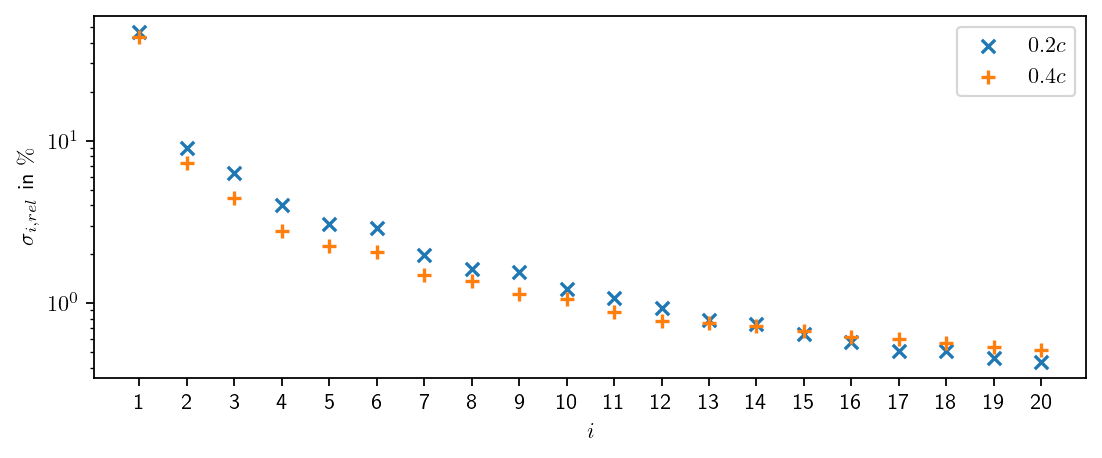

In [16]:
fig, ax = plt.subplots(figsize=(8, 3))

n_show = 20
ax.scatter(range(1, n_show+1), svd_z25.s_rel[:n_show], marker="x", label=r"$0.2c$")
ax.scatter(range(1, n_show+1), svd_z50.s_rel[:n_show], marker="+", label=r"$0.4c$")
ax.legend()
ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$\sigma_{i,rel}$ in $\%$")
ax.set_xticks(range(1, n_show+1))
ax.set_xticklabels(range(1, n_show+1))
ax.set_yscale("log")
plt.show()

Cumulative variance using 244 modes: 99.00
Cumulative variance using 375 modes: 99.00


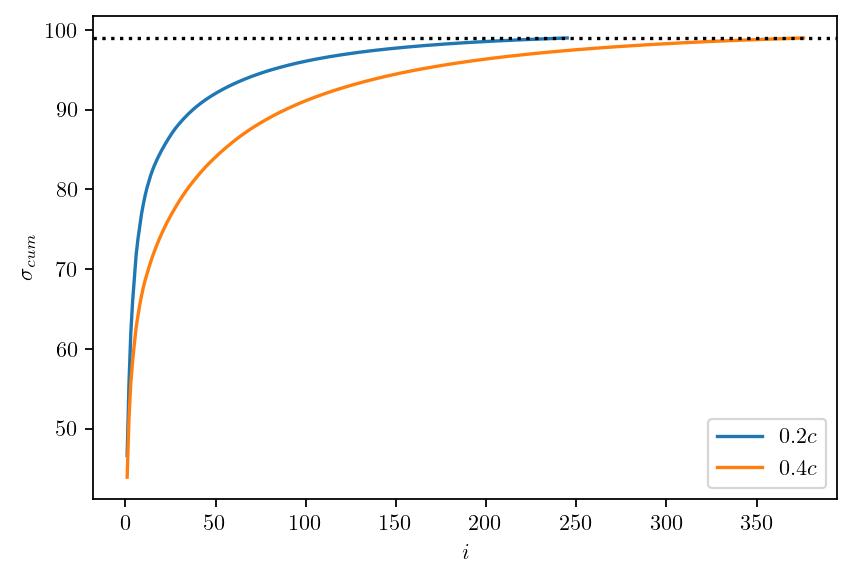

In [17]:
i99_z25 = pt.argmin((svd_z25.s_cum - 99.0).abs()).item()
i99_z50 = pt.argmin((svd_z50.s_cum - 99.0).abs()).item()
print(f"Cumulative variance using {i99_z25:d} modes: {svd_z25.s_cum[i99_z25]:2.2f}")
print(f"Cumulative variance using {i99_z50:d} modes: {svd_z50.s_cum[i99_z50]:2.2f}")
plt.plot(range(1, i99_z25+2), svd_z25.s_cum[:i99_z25+1], label=r"$0.2c$")
plt.plot(range(1, i99_z50+2), svd_z50.s_cum[:i99_z50+1], label=r"$0.4c$")
plt.axhline(99, ls=":", c="k")
plt.xlabel("$i$")
plt.ylabel(r"$\sigma_{cum}$")
plt.legend()
plt.show()

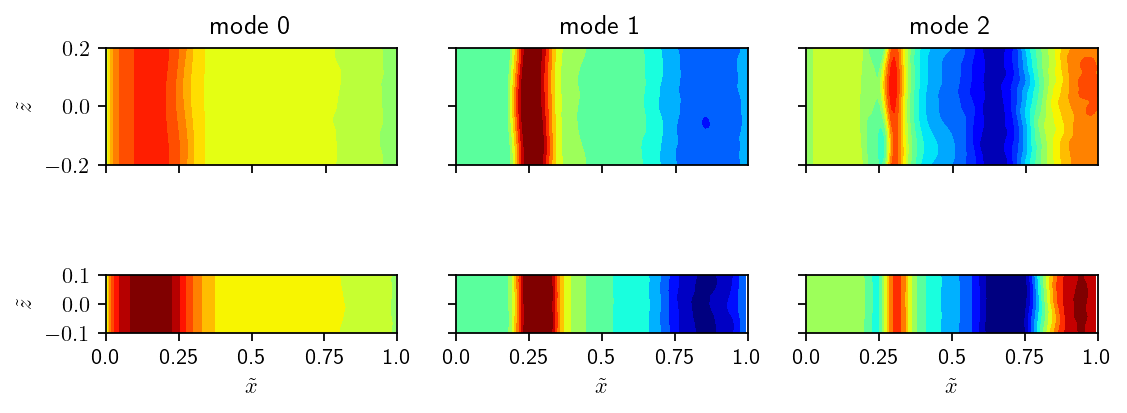

In [18]:
fig, axarr = plt.subplots(2, 3, figsize=(8, 3))

vmin = -0.025
vmax = 0.025

for i in range(3):
    tri = axarr[0, i].tricontourf(x_z50_up, z_z50_up, svd_z50.U[:, i], levels=15, cmap="jet", vmin=vmin, vmax=vmax)
    axarr[1, i].tricontourf(x_z25_up, z_z25_up, svd_z25.U[:, i], levels=15, cmap="jet", vmin=vmin, vmax=vmax)
    if i > 0:
        axarr[0, i].set_yticklabels([])
        axarr[1, i].set_yticklabels([])
    axarr[0, i].set_xticklabels([])
    axarr[0, i].set_title(f"mode {i}")
    axarr[1, i].set_xlabel(r"$\tilde{x}$")
    axarr[1, i].set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
    axarr[1, i].set_xticklabels([0.0, 0.25, 0.5, 0.75, 1.0])
    
axarr[0, 0].set_ylabel(r"$\tilde{z}$")
axarr[1, 0].set_ylabel(r"$\tilde{z}$")

for ax in axarr.ravel():
    ax.set_aspect("equal")
    
#plt.subplots_adjust(hspace=-0.5)
#cmap = mpl.cm.jet
#bounds = np.arange(vmin, vmax*1.001, 0.005)
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
#sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
#cbar = fig.colorbar(sm, ax=axarr.ravel().tolist(), fraction=0.012, pad=0.03)

plt.savefig(output + "naca_svd_surface_modes.svg", bbox_inches="tight")
plt.savefig(output + "naca_svd_surface_modes.png", bbox_inches="tight")
plt.savefig(output + "naca_svd_surface_modes.pdf", bbox_inches="tight")

plt.show()

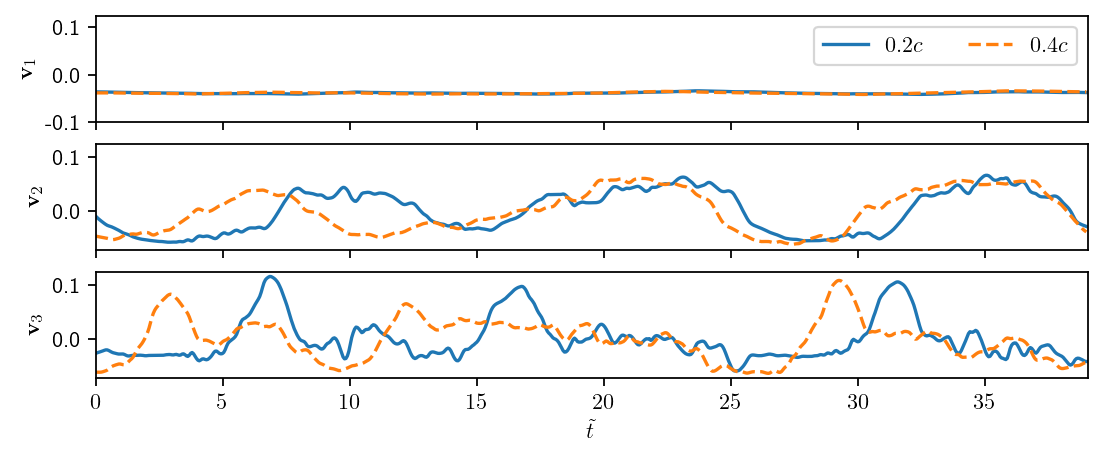

In [19]:
fig, axarr = plt.subplots(3, figsize=(8, 3), sharex=True, sharey=True)

for i in range(3):
    axarr[i].plot(dtimes_z25[start_idx:end_idx]-dtimes_z25[start_idx], svd_z25.V[:, i], ls="-", label=r"$0.2c$")
    axarr[i].plot(dtimes_z50[start_idx:end_idx]-dtimes_z50[start_idx], svd_z50.V[:, i], ls="--", label=r"$0.4c$")
    axarr[i].set_ylabel(r"$\mathbf{{ v }}_{:d}$".format(i+1))
    
axarr[0].set_xlim(0, dtimes_z25[end_idx]-dtimes_z25[start_idx])
axarr[-1].set_xlabel(r"$\tilde{t}$")
axarr[0].legend(ncol=2)
axarr[0].set_yticks([-0.1, 0.0, 0.1])
axarr[0].set_yticklabels([-0.1, 0.0, 0.1])
plt.show()

In [20]:
dt = (times_z25[1] - times_z25[0]).item()
n_samples = svd_z25.V.shape[0]

for i in range(5):
    f, a = welch(svd_z25.V[:, i].numpy(), fs=1/dt, nperseg=n_samples, nfft=n_samples)
    amax = np.argmax(a),
    print(f"mode {i}, 0.2c:", normalize_frequency(f[amax]), a[amax])
    f, a = welch(svd_z50.V[:, i].numpy(), fs=1/dt, nperseg=n_samples, nfft=n_samples)
    amax = np.argmax(a)
    print(f"mode {i}, 0.4c:", normalize_frequency(f[amax]), a[amax])
    print("-"*20)

mode 0, 0.2c: 0.6433509409244409 1.0096469e-07
mode 0, 0.4c: 0.6433509409244409 9.754713e-08
--------------------
mode 1, 0.2c: 0.6433509409244409 4.1061532e-05
mode 1, 0.4c: 0.6433509409244409 4.6205914e-05
--------------------
mode 2, 0.2c: 0.6433509409244409 1.8868812e-05
mode 2, 0.4c: 0.4289006272829606 1.9869842e-05
--------------------
mode 3, 0.2c: 1.7156025091318423 7.896553e-06
mode 3, 0.4c: 1.0722515682074014 1.175749e-05
--------------------
mode 4, 0.2c: 0.6433509409244409 1.51249e-05
mode 4, 0.4c: 1.0722515682074014 1.0644143e-05
--------------------


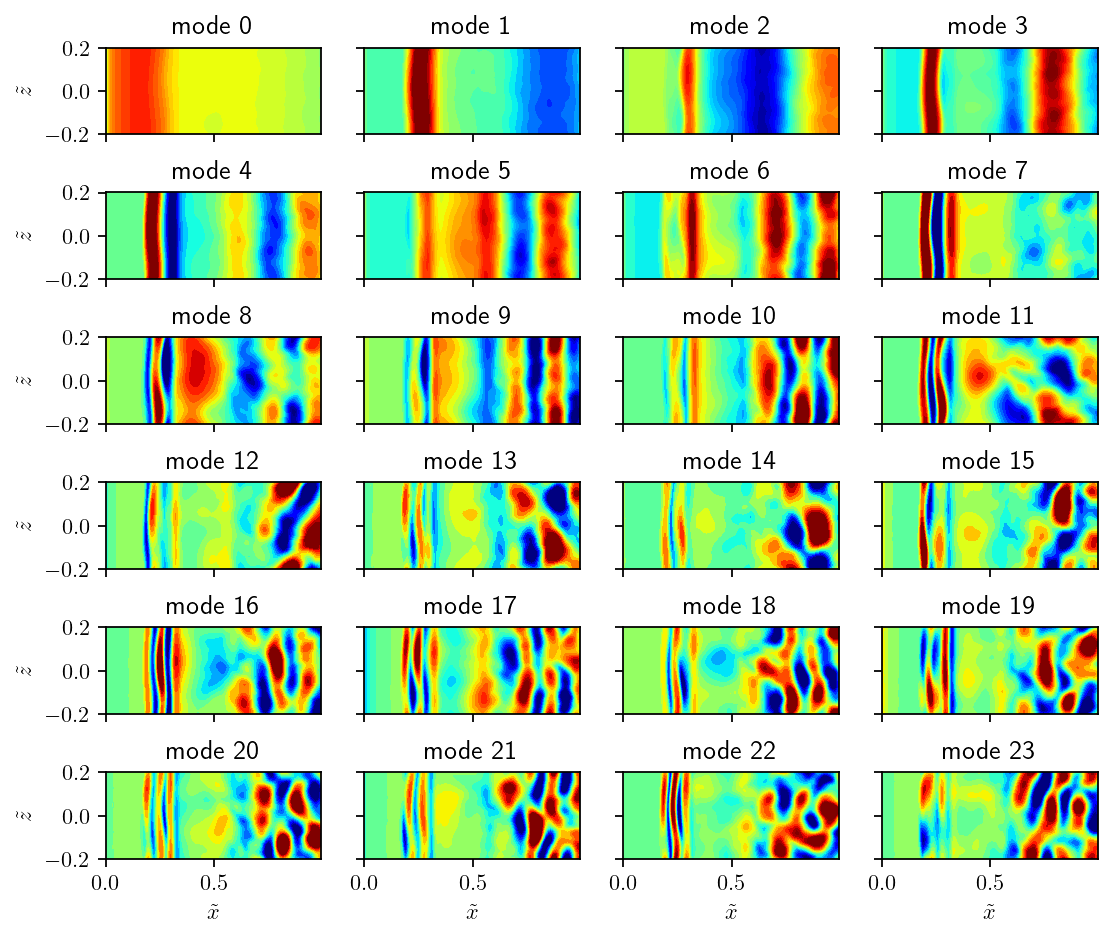

In [21]:
fig, axarr = plt.subplots(6, 4, figsize=(8, 7), sharex=True, sharey=True)

vmin = -0.025
vmax = 0.025

count = 0
for i in range(6):
    for j in range(4):
        axarr[i, j].tricontourf(x_z50_up, z_z50_up, svd_z50.U[:, count], levels=30, cmap="jet", vmin=vmin, vmax=vmax)
        axarr[i, j].set_aspect("equal")
        axarr[i, j].set_title(f"mode {count}")
        count += 1
        
for ax in axarr[:, 0]:
    ax.set_ylabel(r"$\tilde{z}$")
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")

plt.show()

## Dynamic mode decomposition

In [22]:
dmd_z25 = DMD(dm_z25_up, dt=dt, optimal=True)
print(dmd_z25)
dmd_z50 = DMD(dm_z50_up, dt=dt, optimal=True)
print(dmd_z50)

SVD:
SVD of a 4550x279 data matrix
Selected/optimal rank: 279/279
data type: torch.float32 (4b)
truncated SVD size: 5.5769Mb
LSQ:
Overall DMD size: 15.8581Mb
SVD:
SVD of a 8925x286 data matrix
Selected/optimal rank: 286/286
data type: torch.float32 (4b)
truncated SVD size: 10.4900Mb
LSQ:
Overall DMD size: 30.5906Mb


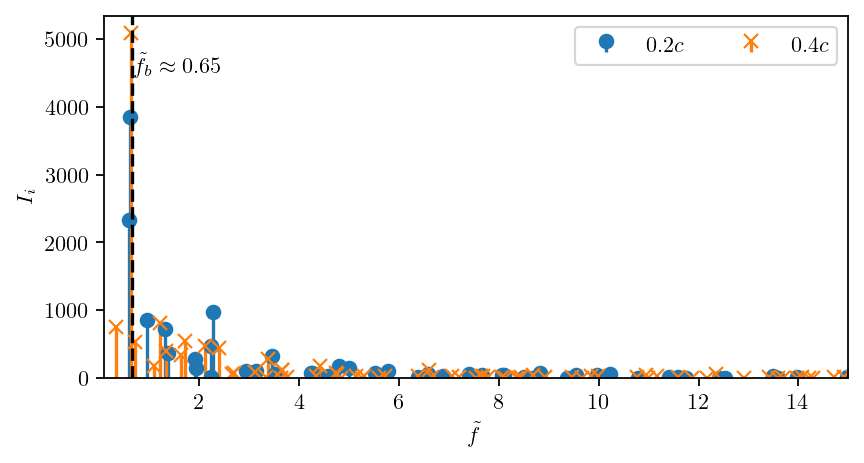

In [23]:
pos_z25 = dmd_z25.frequency > 1
pos_z50 = dmd_z50.frequency > 1
imp_z25 = dmd_z25.integral_contribution
imp_z50 = dmd_z50.integral_contribution

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.stem(normalize_frequency(dmd_z25.frequency[pos_z25].numpy()), imp_z25[pos_z25].numpy(), basefmt="none", linefmt="C0-", label=r"$0.2c$")
ax.stem(normalize_frequency(dmd_z50.frequency[pos_z50].numpy()), imp_z50[pos_z50].numpy(), basefmt="none", linefmt="C1-", markerfmt="C1x", label=r"$0.4c$")
ax.set_xlabel(r"$\tilde{f}$")
ax.set_ylabel(r"$I_i$")
ax.legend(ncol=2)
ax.set_xlim(0.1, 15)
ax.set_ylim(0)
ax.axvline(0.65, ls="--", c="k")
ax.text(0.7, 4500, r"$\tilde{{f}}_{b}\approx 0.65$")

plt.savefig(output + "naca_dmd_surface_freq.svg", bbox_inches="tight")
plt.savefig(output + "naca_dmd_surface_freq.png", bbox_inches="tight")
plt.savefig(output + "naca_dmd_surface_freq.pdf", bbox_inches="tight")

plt.show()

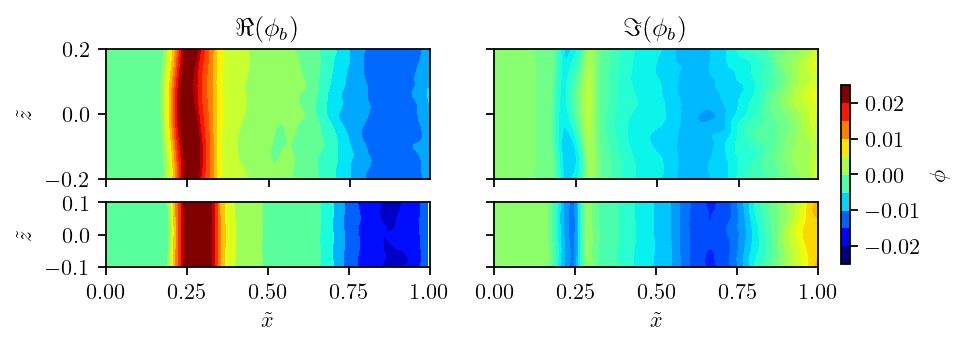

In [24]:
fig, axarr = plt.subplots(2, 2, figsize=(6, 3), sharex=True)

vmin = -0.025
vmax = 0.025

tri = axarr[0, 0].tricontourf(x_z50_up, z_z50_up, dmd_z50.modes[:, 252].real, levels=15, cmap="jet", vmin=vmin, vmax=vmax)
axarr[0, 1].tricontourf(x_z50_up, z_z50_up, dmd_z50.modes[:, 252].imag, levels=15, cmap="jet", vmin=vmin, vmax=vmax)
axarr[1, 0].tricontourf(x_z25_up, z_z25_up, dmd_z25.modes[:, 239].real, levels=15, cmap="jet", vmin=vmin, vmax=vmax)
axarr[1, 1].tricontourf(x_z25_up, z_z25_up, dmd_z25.modes[:, 239].imag, levels=15, cmap="jet", vmin=vmin, vmax=vmax)

axarr[0, 1].set_yticklabels([])
axarr[1, 1].set_yticklabels([])
axarr[1, 0].set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
axarr[1, 1].set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
axarr[0, 0].set_ylabel(r"$\tilde{z}$")
axarr[1, 0].set_ylabel(r"$\tilde{z}$")
axarr[1, 0].set_xlabel(r"$\tilde{x}$")
axarr[1, 1].set_xlabel(r"$\tilde{x}$")
axarr[0, 0].set_title(r"$\Re (\mathbf{\phi}_b)$")
axarr[0, 1].set_title(r"$\Im (\mathbf{\phi}_b)$")


for ax in axarr.ravel():
    ax.set_aspect("equal")
    
plt.subplots_adjust(hspace=-0.5)
cmap = mpl.cm.jet
bounds = np.arange(vmin, vmax*1.001, 0.005)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
cbar = fig.colorbar(sm, ax=axarr.ravel().tolist(), fraction=0.012, pad=0.03)
cbar.ax.set_ylabel(r"$\mathbf{\phi}$")

plt.savefig(output + "naca_dmd_surface_bmode.svg", bbox_inches="tight")
plt.savefig(output + "naca_dmd_surface_bmode.png", bbox_inches="tight")
plt.savefig(output + "naca_dmd_surface_bmode.pdf", bbox_inches="tight")

plt.show()

In [25]:
# DMD of ref. 1 data
dmd_z25_r1 = DMD(dm_z25_r1_up, dt=dt, optimal=True)
print(dmd_z25_r1)

SVD:
SVD of a 6240x285 data matrix
Selected/optimal rank: 285/285
data type: torch.float32 (4b)
truncated SVD size: 7.5342Mb
LSQ:
Overall DMD size: 21.7242Mb


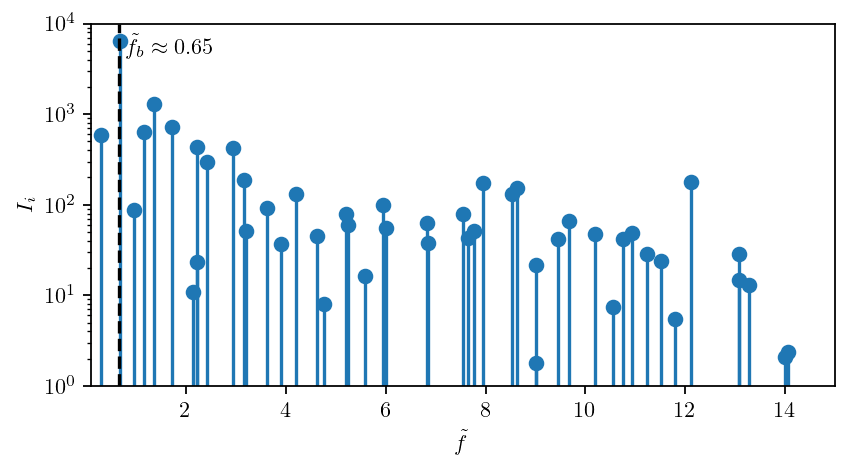

In [26]:
pos_z25_r1 = dmd_z25_r1.frequency > 1
imp_z25_r1 = dmd_z25_r1.integral_contribution

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.stem(normalize_frequency(dmd_z25_r1.frequency[pos_z25_r1].numpy()), imp_z25_r1[pos_z25_r1].numpy(), basefmt="none", linefmt="C0-")
ax.set_xlabel(r"$\tilde{f}$")
ax.set_ylabel(r"$I_i$")
ax.set_xlim(0.1, 15)
#ax.set_ylim(0)
ax.set_ylim(1, 10000)
ax.set_yscale("log")
ax.axvline(0.65, ls="--", c="k")
ax.text(0.8, 4500, r"$\tilde{{f}}_{b}\approx 0.65$")

plt.savefig(output + "naca_dmd_surface_freq_ref1.svg", bbox_inches="tight")
plt.savefig(output + "naca_dmd_surface_freq_ref1.png", bbox_inches="tight")
plt.savefig(output + "naca_dmd_surface_freq_ref1.pdf", bbox_inches="tight")

plt.show()

In [27]:
topk = dmd_z25_r1.top_modes(30, integral=True)

for i in topk:
    if dmd_z25_r1.frequency[i] > 1:
        print(i.item(), normalize_frequency(dmd_z25_r1.frequency[i].item()))

246 0.6786204529255999
249 1.3508746610169529
264 1.7134924309764643
276 1.1680581505470755
266 0.2982359129206621
244 2.2246837605997403
260 2.9495849123573383
262 2.416815611765069
242 3.1539588473257907
170 12.118121302454698
199 7.947639378303209
201 8.621365820024925
232 4.200945792005652
205 8.526074451219955


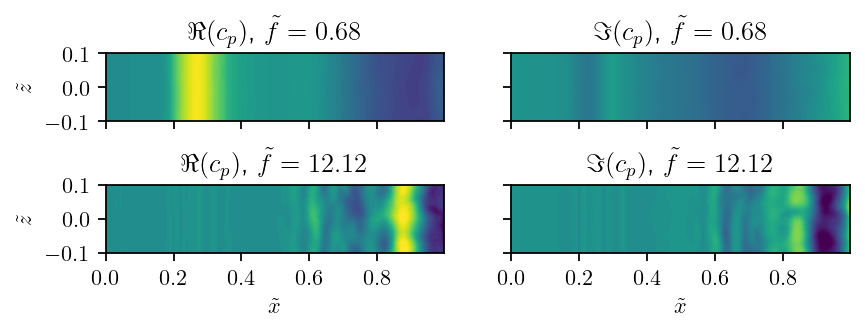

In [28]:
fig, axarr = plt.subplots(2, 2, figsize=(6, 2), sharex=True, sharey=True)

vmin, vmax = -0.03, 0.03

axarr[0, 0].tricontourf(x_z25_r1_up, z_z25_r1_up, dmd_z25_r1.modes[:, 246].real, levels=60, cmap="viridis", vmin=vmin, vmax=vmax)
axarr[0, 1].tricontourf(x_z25_r1_up, z_z25_r1_up, dmd_z25_r1.modes[:, 246].imag, levels=60, cmap="viridis", vmin=vmin, vmax=vmax)
axarr[1, 0].tricontourf(x_z25_r1_up, z_z25_r1_up, dmd_z25_r1.modes[:, 170].real, levels=60, cmap="viridis", vmin=vmin, vmax=vmax)
axarr[1, 1].tricontourf(x_z25_r1_up, z_z25_r1_up, dmd_z25_r1.modes[:, 170].imag, levels=60, cmap="viridis", vmin=vmin, vmax=vmax)

for ax in axarr.flatten():
    ax.set_aspect("equal")
    
axarr[1, 0].set_xlabel(r"$\tilde{x}$")
axarr[1, 1].set_xlabel(r"$\tilde{x}$")
axarr[0, 0].set_ylabel(r"$\tilde{z}$")
axarr[1, 0].set_ylabel(r"$\tilde{z}$")

axarr[0, 0].set_title(r"$\Re (c_p)$, $\tilde{{f}} = {:2.2f}$".format(normalize_frequency(dmd_z25_r1.frequency[246])))
axarr[0, 1].set_title(r"$\Im (c_p)$, $\tilde{{f}} = {:2.2f}$".format(normalize_frequency(dmd_z25_r1.frequency[246])))
axarr[1, 0].set_title(r"$\Re (c_p)$, $\tilde{{f}} = {:2.2f}$".format(normalize_frequency(dmd_z25_r1.frequency[170])))
axarr[1, 1].set_title(r"$\Im (c_p)$, $\tilde{{f}} = {:2.2f}$".format(normalize_frequency(dmd_z25_r1.frequency[170])))

plt.savefig(output + "naca_dmd_surface_modes_ref1.svg", bbox_inches="tight")
plt.savefig(output + "naca_dmd_surface_modes_ref1.png", bbox_inches="tight")
plt.savefig(output + "naca_dmd_surface_modes_ref1.pdf", bbox_inches="tight")

plt.show()

In [29]:
def animate_reconstruction(rz25, rz50, title, n_frames, vmin, vmax):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(4, 3), sharex=True, dpi=640, gridspec_kw={'height_ratios': [2, 1]})
    plt.subplots_adjust(bottom=0.15, top=0.95, left=0.15, right=0.95, hspace=-0.1)
    def animate(i):
        print("\r", f"frame {i:03d}", end="")
        ax1.clear()
        ax2.clear()
        ax1.tricontourf(x_z50_up, z_z50_up, rz50[:, i], levels=60, cmap="jet", vmin=vmin, vmax=vmax)
        ax2.tricontourf(x_z25_up, z_z25_up, rz25[:, i], levels=60, cmap="jet", vmin=vmin, vmax=vmax)
        ax1.set_aspect("equal")
        ax2.set_aspect("equal")
        ax2.set_xlabel(r"$\tilde{x}$")
        ax1.set_ylabel(r"$\tilde{z}$")
        ax2.set_ylabel(r"$\tilde{z}$")
        ax2.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
        ax1.set_title(title)
    return FuncAnimation(fig, animate,  frames=n_frames, repeat=True)

In [30]:
#writer = FFMpegWriter(fps=60, bitrate=1800)

#anim = animate_reconstruction(
#    dmd_z25.partial_reconstruction({222, 240, 239})[:, ::2],
#    dmd_z50.partial_reconstruction({230, 252, 253})[:, ::2],
#    "buffet mode",
#    dm_z25_up[:, ::2].shape[1],
#    -1.5, 0.5
#)
#plt.close()
#anim.save(f"{output}naca_dmd_surface_buffet.mp4", writer=writer)